# Predicting Renfe Ticket Prices Using AWS XGBoost


---

In this project I will use AWS SageMaker's build-in XGBoost algorithm to analyze the Renfe (High-speed train) ticket prices. The dataset is from [Kaggle](https://www.kaggle.com/thegurus/spanish-high-speed-rail-system-ticket-pricing). 

## Analysis Process

The following are the key steps of the analysis process.

0. Setting up the notebook
1. Read the data into notebook and prepare the data
2. Data exploration
3. Create dummy variables for the categorical variables
4. Upload csv files to S3
5. Build and train the XGBoost model
6. Use the trained model to make predictions on test data
7. Evaluate the model
8. Compare the model with LGBMRegressor model


## Step 0: Setting up the notebook

Import libraries for data preparation and exploratory analysis.

In [1]:
!pip install xgboost

    100% |████████████████████████████████| 142.8MB 344kB/s eta 0:00:01   47% |███████████████▎                | 68.4MB 53.3MB/s eta 0:00:02
fastai 1.0.52 requires nvidia-ml-py3, which is not installed.
thinc 6.12.1 has requirement msgpack<0.6.0,>=0.5.6, but you'll have msgpack 0.6.0 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.model_selection
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor

import scipy.stats as stats

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format

Import SageMaker modules. 

In [26]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

session = sagemaker.Session()
role = get_execution_role()

## Step 1: Read the data into Notebook and prepare the data

The data is in CSV. Preparation includes dropping the missing data rows and extracting Year, Month, Day, Day of Week, Hour information. By intuition these columns are relevant to ticket prices.

In [3]:
# Read in the dataset
data=pd.read_csv('../data/renfe.csv')
data.head()

,Unnamed: 0,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
1,1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo
2,2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo
3,3,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.40,Preferente,Promo
4,4,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:30:00,2019-05-29 11:14:00,ALVIA,nan,Turista,Promo


In [4]:
# Drop the rowid and insert_date columns as they don't add value to the prediction model
# Also drop the missing values
# Do this at the beginning to save storage and memory
data=data.drop(data.columns[[0,1]], axis=1)
data=data.dropna()

In [5]:
# Convert date columns for extracting components later.
# Calculate the duration hours
data['start_dt'] = [datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in data["start_date"]]
data['end_dt'] = [datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in data["end_date"]]
data['duration_hours']=(data['end_dt']-data['start_dt']).astype('timedelta64[h]')

print(f"Start time range: {data['start_dt'].min()} -- {data['start_dt'].max()}")
print(f"End time range: {data['end_dt'].min()} -- {data['end_dt'].max()}")

Start time range: 2019-04-12 05:50:00 -- 2019-07-07 22:14:00
End time range: 2019-04-12 08:38:00 -- 2019-07-08 04:31:00


In [6]:
# Create origin destination pair. 
data['od']=data['origin']+'_'+data['destination']

# Extract components in the start date column. No need for end date since they are correlated.
data['start_month']=[d.month for d in data['start_dt']]
data['start_day']=[d.day for d in data['start_dt']]
data['start_weekday']=[d.dayofweek for d in data['start_dt']]
data['start_hour']=[d.hour for d in data['start_dt']]

data=data.drop(['start_dt', 'start_date', 'end_dt', 'end_date'], axis=1)

## Step 2: Data Exploration

Perform univariate and multi-variate data exploration. Try to understand the overal distribution of ticket prices, start hours, and how other columns are related to the ticket prices. 

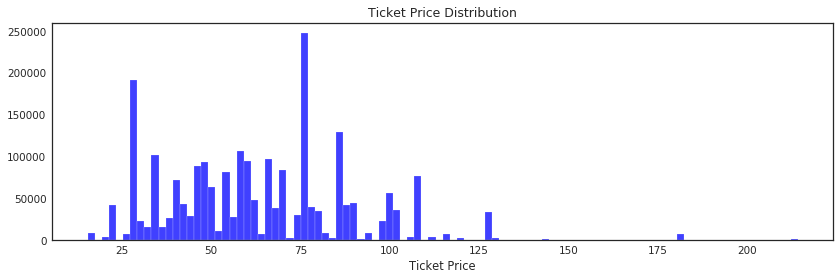

In [22]:
# Price distribution across all data
plt.figure(figsize = (14, 4))
n, bins, patches = plt.hist(data['price'], 100, facecolor='blue', alpha=0.75, ec='white')
plt.xlabel('Ticket Price')
plt.title('Ticket Price Distribution')
plt.show();

In [23]:
# Analyze the high price tickets
s1 = data[['price','train_type', 'train_class', 'start_month', 'fare']]
s1=s1[s1['price']>130]

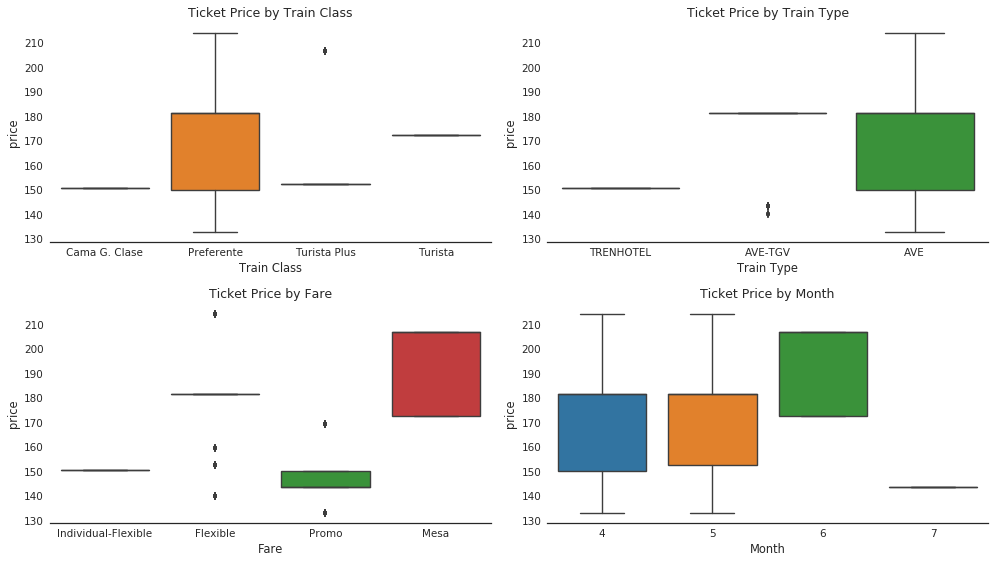

In [24]:
# These are for the high price ticket only.
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
sns.boxplot(x="train_class", y="price", data=s1)
plt.xlabel('Train Class')
plt.title('Ticket Price by Train Class')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,2)
sns.boxplot(x="train_type", y="price", data=s1)
plt.xlabel('Train Type')
plt.title('Ticket Price by Train Type')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,3)
sns.boxplot(x="fare", y="price", data=s1)
plt.xlabel('Fare')
plt.title('Ticket Price by Fare')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,4)
sns.boxplot(x="start_month", y="price", data=s1)
plt.xlabel('Month')
plt.title('Ticket Price by Month')
sns.despine(left=True)
plt.tight_layout()

plt.show()

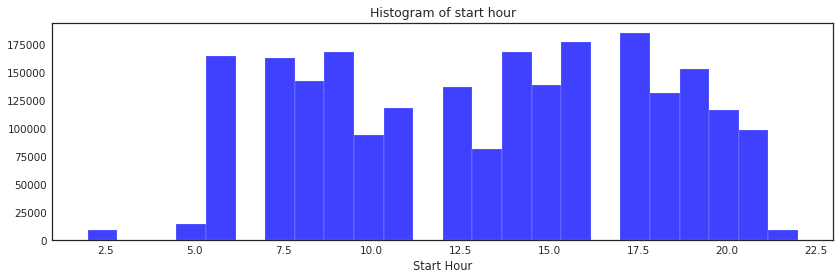

In [25]:
# Distribution of no of starts by hour for all tickets
plt.figure(figsize = (14, 4))
n, bins, patches = plt.hist(data['start_hour'], 24, facecolor='blue', alpha=0.75, ec='white')
plt.xlabel('Start Hour')
plt.title('Histogram of start hour')
plt.show();

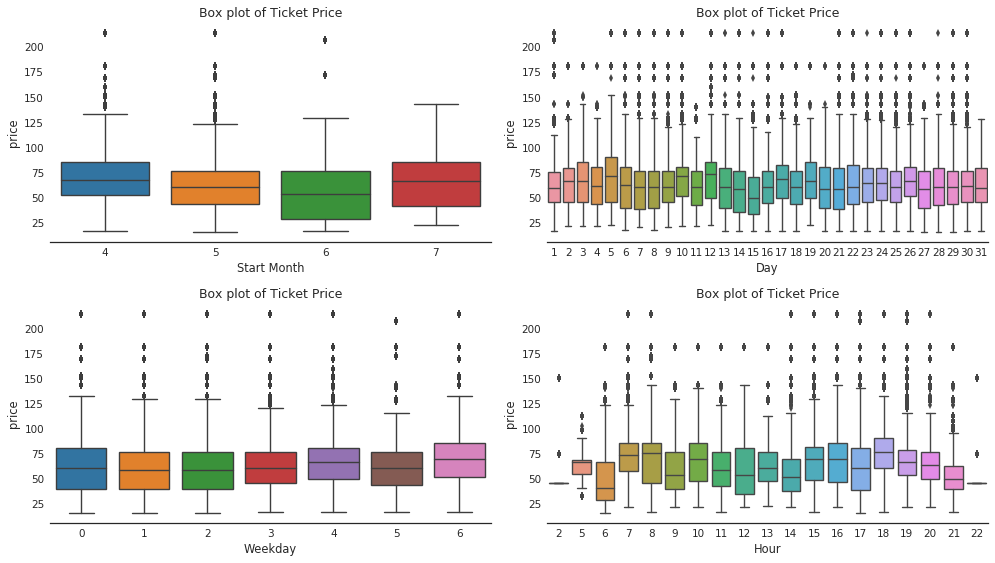

In [26]:
# Price by other variables for all tickets
plt.figure(figsize=(14,8))

plt.subplot(2,2,1)
# plt.subplots_adjust(wspace=10.4)
sns.boxplot(x="start_month", y="price", data=data)
plt.xlabel('Start Month')
plt.title('Box plot of Ticket Price')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,2)
sns.boxplot(x="start_day", y="price", data=data)
plt.xlabel('Day')
plt.title('Box plot of Ticket Price')
sns.despine(left=True)
plt.tight_layout();

plt.subplot(2,2,3)
sns.boxplot(x="start_weekday", y="price", data=data)
plt.xlabel('Weekday')
plt.title('Box plot of Ticket Price')
sns.despine(left=True)
plt.tight_layout();

plt.subplot(2,2,4)
sns.boxplot(x="start_hour", y="price", data=data)
plt.xlabel('Hour')
plt.title('Box plot of Ticket Price')
sns.despine(left=True)
plt.tight_layout();

In [27]:
def get_f_p(df, var, idx_arr):
    """ANOVA - Get F statistic and p value"""
    a={}
    for i in df[var].unique():
        a[i]=df.loc[df[var]==i, 'price']

    groups=[a[i] for i in idx_arr]
    
    f_stat, p_value=stats.f_oneway(*groups)
    print(f'F Stat is: {f_stat}, P Value is: {p_value}.')

In [28]:
# Perform Anova Tests on select variables
get_f_p(data, 'start_month', [4,5,6,7])
get_f_p(data, 'start_day', [2, 4, 6, 8, 10, 12, 14, 16])
get_f_p(data, 'start_weekday', [0, 1, 2, 3, 4, 5, 6])
get_f_p(data, 'start_hour', [5, 7, 9, 11, 13])

F Stat is: 18809.292953094857, P Value is: 0.0.
F Stat is: 1199.4208299602747, P Value is: 0.0.
F Stat is: 6937.6136853834405, P Value is: 0.0.
F Stat is: 6873.574293091011, P Value is: 0.0.


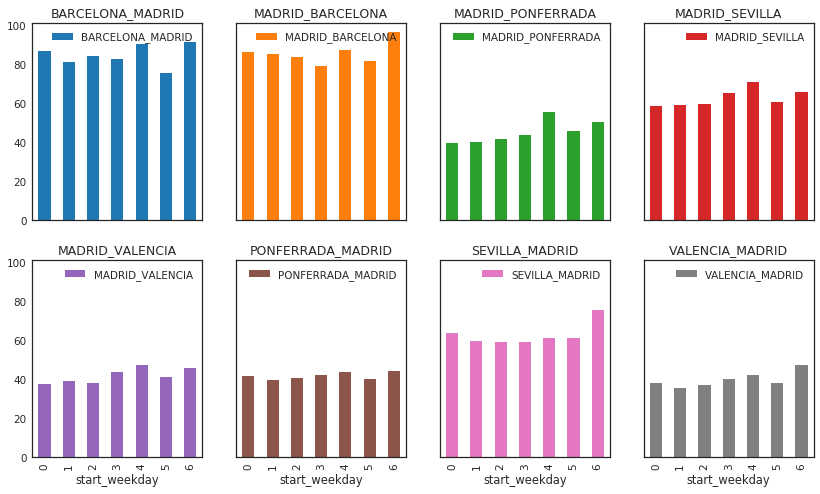

In [29]:
# Price by origin/destination 
pd.pivot_table(data, values = "price", columns = "od", 
               index = "start_weekday").plot.bar(subplots = True, figsize=(14,8), layout=(2,4), sharey=True);

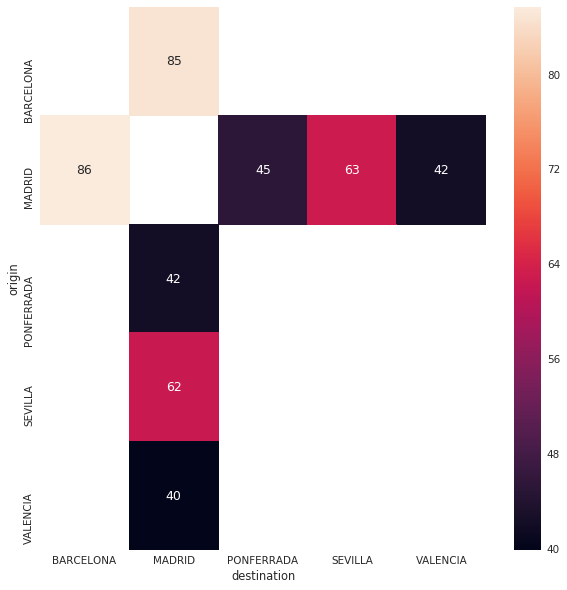

In [30]:
# price by origin destination. Light color means high.
plt.figure(figsize=(10,10))

sns.heatmap(pd.pivot_table(data, values = "price", columns = "destination", 
               index = "origin"), annot=True)

### Step 3: Create dummy variables

Create dummy variables for the select columns. Finalize the input variables for the model.

In [14]:
data.columns.values

array(['origin', 'destination', 'train_type', 'price', 'train_class',
       'fare', 'duration_hours', 'od', 'start_month', 'start_day',
       'start_weekday', 'start_hour'], dtype=object)

In [7]:
# Create a small stratified dataset just for hyper parameter tuning. 
df=data.copy()
df_small=data.groupby(['od', 'train_type', 'train_class', 'fare'], group_keys=False).apply(lambda x: x.sample(min(len(x), 5000))).reset_index(drop=True)

In [8]:
# One hot encode the categorical variables
dummy_fields = ['od', 'train_type', 'train_class', 'fare', 'start_month', 
                'start_day', 'start_weekday', 'start_hour']

for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
    
    dummies_s = pd.get_dummies(df_small[each], prefix=each, drop_first=False)
    df_small = pd.concat([df_small, dummies_s], axis=1)


fields_to_drop = ['origin', 'destination', 'od', 'train_type', 'train_class',
       'fare', 'start_month', 'start_day', 'start_weekday', 'start_hour']
df = df.drop(fields_to_drop, axis=1)
df_small = df_small.drop(fields_to_drop, axis=1)

In [9]:
print(f'df: {df.shape}')
print(f'df_small: {df_small.shape}')

df: (2269090, 99)
df_small: (415799, 99)


In [21]:
X_pd = df.drop(columns=['price'])
Y_pd = df['price']

In [22]:
# Split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_pd, Y_pd, test_size=0.33)

# Split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

In [23]:
data_dir = '../data/renfe'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [24]:
# Create csv files on local instance. Don't include Y in test data.
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

## Step 3.5: Build XGBoost model using SKLearn and tune the hyperparameters

Build an XGBoost model in sklearn and use the tools available to tune the hyperparameters. This section is added based on reviewer's suggestion.

In [10]:
# Prepare data for hyper parameters tuning
X_pd_small = df_small.drop(columns=['price'])
Y_pd_small = df_small['price']

X_train_small, X_test_small, Y_train_small, Y_test_small = sklearn.model_selection.train_test_split(
    X_pd_small, Y_pd_small, test_size=0.33)

X_train_small, X_val_small, Y_train_small, Y_val_small = sklearn.model_selection.train_test_split(
    X_train_small, Y_train_small, test_size=0.33)

In [ ]:
# Hyper parameters grid
# params = {'min_child_weight':[5,6], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,9)],
# 'colsample_bytree':[i/10.0 for i in range(6,9)], 'max_depth': [5,6,7]}

# params = {'max_depth': [5,6,7]}
# params = {'learning_rate': [0.01, 0.1, 0.2]}
params = {'min_child_weight':[5,7,9],
          'max_depth': [7,8,10],  
          'learning_rate': [0.2, 0.9],
          'subsample':[0.5],
          'n_estimators': [500]
         }

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params, scoring='explained_variance', cv=3)
grid.fit(X_train_small, Y_train_small)

[13:34:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:42:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:44:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:47:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:49:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
best_params = grid.best_params_
model = grid.best_estimator_
score = grid.best_score_

print('\tBest Estimator\t%s\t%f' % (str(best_params) ,abs(score)))

	Best Estimator	{'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.5}	0.988220


In [17]:
sklearn_xgb_y_pred=grid.best_estimator_.predict(X_test_small)
sklearn_xgb_rmse = np.sqrt(mean_squared_error(Y_test_small, sklearn_xgb_y_pred))
print("RMSE: %f" % (sklearn_xgb_rmse))

RMSE: 3.175479


In [18]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


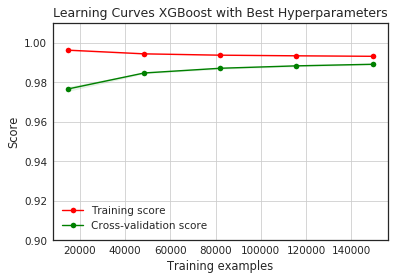

In [ ]:
title = r"Learning Curves XGBoost with Best Hyperparameters"

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = XGBRegressor(objective ='reg:squarederror', learning_rate = 0.2,
                max_depth = 10, min_child_weight = 5, n_estimators = 1000)
plot_learning_curve(estimator, title, X_train_small, Y_train_small, (0.9, 1.01), cv=cv, n_jobs=-1)

plt.show()

## Step 4: Upload the csv files to S3

Upload csv files to S3 for a batch transform and model training job using AWS SageMaker.

In [27]:
# Upload data to S3
prefix = 'renfe'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Step 5: Build and train the XGBoost Model

Use AWS's build in XGBoost algorithm to build the model. First, get a XGBoost container; Second, build the model; Third, set the hyperparameters.

In [29]:
# Create container for XGBoost.
container = get_image_uri(session.boto_region_name, 'xgboost')

# Build the XGBoost model.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

In [30]:
xgb.set_hyperparameters(max_depth=10,
                        eta=0.2,
                        min_child_weight=5,
                        subsample=0.5,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=1500)

In [31]:
# Get the csv input data from S3. 
# Use training data to train the model and use the validation data to control overfitting.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2019-07-19 20:48:00 Starting - Starting the training job...
2019-07-19 20:48:03 Starting - Launching requested ML instances......
2019-07-19 20:49:04 Starting - Preparing the instances for training......
2019-07-19 20:50:29 Downloading - Downloading input data
2019-07-19 20:50:29 Training - Downloading the training image...
2019-07-19 20:50:46 Training - Training image download completed. Training in progress.
Arguments: train
[2019-07-19:20:50:47:INFO] Running standalone xgboost training.
[2019-07-19:20:50:47:INFO] File size need to be processed in the node: 295.08mb. Available memory size in the node: 8432.86mb
[2019-07-19:20:50:47:INFO] Determined delimiter of CSV input is ','
[20:50:47] S3DistributionType set as FullyReplicated
[20:50:49] 1018594x98 matrix with 99822212 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-07-19:20:50:49:INFO] Determined delimiter of CSV input is ','
[20:50:49] S3DistributionType set as FullyReplicated
[20:50:50] 

[20:54:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=10
[40]#011train-rmse:5.37398#011validation-rmse:5.38481
[20:54:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10
[41]#011train-rmse:5.34734#011validation-rmse:5.35889
[20:54:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[42]#011train-rmse:5.3224#011validation-rmse:5.33459
[20:54:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 pruned nodes, max_depth=10
[43]#011train-rmse:5.2925#011validation-rmse:5.30402
[20:54:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 690 extra nodes, 0 pruned nodes, max_depth=10
[44]#011train-rmse:5.25418#011validation-rmse:5.26638
[20:54:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 550 extra nodes, 0 pruned nodes, max_depth=10
[45]#011train-rmse:5.23583#011validation-rmse:5.

[20:57:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 826 extra nodes, 0 pruned nodes, max_depth=10
[85]#011train-rmse:4.59641#011validation-rmse:4.6265
[20:57:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 694 extra nodes, 0 pruned nodes, max_depth=10
[86]#011train-rmse:4.58804#011validation-rmse:4.61854
[20:57:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 560 extra nodes, 0 pruned nodes, max_depth=10
[87]#011train-rmse:4.58158#011validation-rmse:4.61195
[20:57:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 694 extra nodes, 0 pruned nodes, max_depth=10
[88]#011train-rmse:4.56953#011validation-rmse:4.5995
[20:57:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 660 extra nodes, 0 pruned nodes, max_depth=10
[89]#011train-rmse:4.55933#011validation-rmse:4.5891
[20:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 690 extra nodes, 0 pruned nodes, max_depth=10
[90]#011train-rmse:4.54817#011validation-rmse:4.5

[21:00:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 628 extra nodes, 0 pruned nodes, max_depth=10
[129]#011train-rmse:4.29631#011validation-rmse:4.3384
[21:00:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[130]#011train-rmse:4.29298#011validation-rmse:4.33486
[21:00:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 620 extra nodes, 0 pruned nodes, max_depth=10
[131]#011train-rmse:4.28895#011validation-rmse:4.33174
[21:01:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 772 extra nodes, 0 pruned nodes, max_depth=10
[132]#011train-rmse:4.28205#011validation-rmse:4.32542
[21:01:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 810 extra nodes, 0 pruned nodes, max_depth=10
[133]#011train-rmse:4.2764#011validation-rmse:4.32031
[21:01:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=10
[134]#011train-rmse:4.27126#011validation-r

[21:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[173]#011train-rmse:4.16336#011validation-rmse:4.21102
[21:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 776 extra nodes, 0 pruned nodes, max_depth=10
[174]#011train-rmse:4.16105#011validation-rmse:4.20889
[21:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 724 extra nodes, 0 pruned nodes, max_depth=10
[175]#011train-rmse:4.15911#011validation-rmse:4.20701
[21:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[176]#011train-rmse:4.15838#011validation-rmse:4.20621
[21:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 780 extra nodes, 0 pruned nodes, max_depth=10
[177]#011train-rmse:4.1555#011validation-rmse:4.20326
[21:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 0 pruned nodes, max_depth=10
[178]#011train-rmse:4.15257#011validation-

[21:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=10
[218]#011train-rmse:4.09704#011validation-rmse:4.1481
[21:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 604 extra nodes, 0 pruned nodes, max_depth=10
[219]#011train-rmse:4.09597#011validation-rmse:4.1466
[21:07:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 646 extra nodes, 0 pruned nodes, max_depth=10
[220]#011train-rmse:4.09518#011validation-rmse:4.14563
[21:07:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=10
[221]#011train-rmse:4.09447#011validation-rmse:4.1453
[21:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 646 extra nodes, 0 pruned nodes, max_depth=10
[222]#011train-rmse:4.09343#011validation-rmse:4.14396
[21:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=10
[223]#011train-rmse:4.09241#011validation-rm

[21:11:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[264]#011train-rmse:4.05961#011validation-rmse:4.11038
[21:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 614 extra nodes, 0 pruned nodes, max_depth=10
[265]#011train-rmse:4.05922#011validation-rmse:4.11006
[21:11:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10
[266]#011train-rmse:4.05873#011validation-rmse:4.10953
[21:11:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[267]#011train-rmse:4.05822#011validation-rmse:4.10892
[21:11:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=10
[268]#011train-rmse:4.05787#011validation-rmse:4.10881
[21:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 606 extra nodes, 0 pruned nodes, max_depth=10
[269]#011train-rmse:4.05738#011validation

[21:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 670 extra nodes, 0 pruned nodes, max_depth=10
[308]#011train-rmse:4.04124#011validation-rmse:4.09173
[21:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[309]#011train-rmse:4.04104#011validation-rmse:4.09137
[21:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[310]#011train-rmse:4.04076#011validation-rmse:4.09094
[21:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=10
[311]#011train-rmse:4.04012#011validation-rmse:4.09046
[21:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 626 extra nodes, 0 pruned nodes, max_depth=10
[312]#011train-rmse:4.03976#011validation-rmse:4.08986
[21:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[313]#011train-rmse:4.03938#011validation

[21:17:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[354]#011train-rmse:4.02746#011validation-rmse:4.07874
[21:17:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 606 extra nodes, 0 pruned nodes, max_depth=10
[355]#011train-rmse:4.02728#011validation-rmse:4.07856
[21:17:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 620 extra nodes, 0 pruned nodes, max_depth=10
[356]#011train-rmse:4.02713#011validation-rmse:4.07808
[21:18:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 660 extra nodes, 0 pruned nodes, max_depth=10
[357]#011train-rmse:4.0269#011validation-rmse:4.07819
[21:18:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=10
[358]#011train-rmse:4.02677#011validation-rmse:4.07797
[21:18:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 672 extra nodes, 0 pruned nodes, max_depth=10
[359]#011train-rmse:4.02656#011validation-

[21:21:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 720 extra nodes, 0 pruned nodes, max_depth=10
[400]#011train-rmse:4.01882#011validation-rmse:4.07116
[21:21:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 690 extra nodes, 0 pruned nodes, max_depth=10
[401]#011train-rmse:4.01866#011validation-rmse:4.07108
[21:21:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 666 extra nodes, 0 pruned nodes, max_depth=10
[402]#011train-rmse:4.01832#011validation-rmse:4.07081
[21:21:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 642 extra nodes, 0 pruned nodes, max_depth=10
[403]#011train-rmse:4.01823#011validation-rmse:4.07067
[21:21:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 784 extra nodes, 0 pruned nodes, max_depth=10
[404]#011train-rmse:4.01787#011validation-rmse:4.07048
[21:21:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 804 extra nodes, 0 pruned nodes, max_depth=10
[405]#011train-rmse:4.01759#011validation

[21:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 pruned nodes, max_depth=10
[445]#011train-rmse:4.01098#011validation-rmse:4.06194
[21:24:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=10
[446]#011train-rmse:4.01073#011validation-rmse:4.06172
[21:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 570 extra nodes, 0 pruned nodes, max_depth=10
[447]#011train-rmse:4.01064#011validation-rmse:4.06177
[21:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 664 extra nodes, 0 pruned nodes, max_depth=10
[448]#011train-rmse:4.01049#011validation-rmse:4.06141
[21:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 646 extra nodes, 0 pruned nodes, max_depth=10
[449]#011train-rmse:4.01048#011validation-rmse:4.06139
[21:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[450]#011train-rmse:4.0104#011validation-

[21:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 pruned nodes, max_depth=10
[489]#011train-rmse:4.00596#011validation-rmse:4.05748
[21:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[490]#011train-rmse:4.00585#011validation-rmse:4.05788
[21:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 0 pruned nodes, max_depth=10
[491]#011train-rmse:4.0057#011validation-rmse:4.05779
[21:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 650 extra nodes, 0 pruned nodes, max_depth=10
[492]#011train-rmse:4.00568#011validation-rmse:4.05774
[21:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 pruned nodes, max_depth=10
[493]#011train-rmse:4.00555#011validation-rmse:4.05771
[21:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0 pruned nodes, max_depth=10
[494]#011train-rmse:4.00552#011validation-

[21:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 0 pruned nodes, max_depth=10
[533]#011train-rmse:4.00186#011validation-rmse:4.05379
[21:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[534]#011train-rmse:4.00181#011validation-rmse:4.05358
[21:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 0 pruned nodes, max_depth=10
[535]#011train-rmse:4.00175#011validation-rmse:4.05346
[21:31:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=10
[536]#011train-rmse:4.00169#011validation-rmse:4.05341
[21:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 678 extra nodes, 0 pruned nodes, max_depth=10
[537]#011train-rmse:4.00149#011validation-rmse:4.05329
[21:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[538]#011train-rmse:4.00135#011validation

## Step 6: Use the trained model to make predictions on test data

Use the model to make a prediction on the test data. Use SageMaker module to build a transformer; use the transformer to make the predictions. The transformer object will take advantage of sagemaker's batch transform functionality.

In [32]:
# Create transformer object and make predictions.
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [33]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [34]:
xgb_transformer.wait()

.................................................!


## Step 7: Evaluate the model

Here I first build a base model using the average price across all data points. The RMSE error calculated using this information will later be used to evaluate the SageMaker XGBoost model's performance.

In [35]:
# Create base model and calculate RMSE
avg_price=np.mean(Y_test)

Y_base=np.full_like(Y_test, avg_price)

rmse_base = np.sqrt(mean_squared_error(Y_test, Y_base))
print("RMSE BASE: %f" % (rmse_base))

RMSE BASE: 25.803036


Get the predictions from S3. Calculate the RMSE and visualize with a scatterplot.

In [36]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-2-342322197210/xgboost-2019-07-19-21-33-23-496/test.csv.out to ../data/renfe/test.csv.out


In [37]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [38]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE: %f" % (rmse))

RMSE: 4.078219


Text(0.5, 1.0, 'Actual Renfe Price vs Predicted Price')

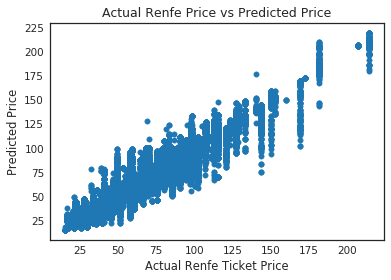

In [39]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Renfe Ticket Price")
plt.ylabel("Predicted Price")
plt.title("Actual Renfe Price vs Predicted Price")

## Step 8: Comparison with LGBMRegressor

LightGBM Regressor implemented by Microsoft provides another way to build regression models. It boosts high accuracy with high efficiency and fast speed. Here I build a LGBM regression model to compare with the XGBoost model.

In [41]:
!pip install lightgbm

    100% |████████████████████████████████| 1.2MB 21.7MB/s ta 0:00:01
fastai 1.0.52 requires nvidia-ml-py3, which is not installed.
thinc 6.12.1 has requirement msgpack<0.6.0,>=0.5.6, but you'll have msgpack 0.6.0 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [42]:
from lightgbm import LGBMRegressor

In [43]:
params = {'min_child_weight':[5,7,9],
          'max_depth': [7,8,10],  
          'learning_rate': [0.2, 0.9],
          'subsample':[0.5],
          'n_estimators': [500]
         }

# Initialize lgbm and GridSearch
lg = LGBMRegressor(nthread=-1) 

lg_grid = GridSearchCV(lg, params, scoring='explained_variance', cv=3)
lg_grid.fit(X_train_small, Y_train_small)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, nthread=-1, num_leaves=31,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_child_weight': [5, 7, 9], 'max_depth': [7, 8, 10], 'learning_rate': [0.2, 0.9], 'subsample': [0.5], 'n_estimators': [500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='explained_variance', verbose=0)

In [44]:
lg_best_params = lg_grid.best_params_
lg_model = lg_grid.best_estimator_
lg_score = lg_grid.best_score_

print('LGBM Best Estimator\t%s\t%f' % (str(lg_best_params) ,abs(lg_score)))

LGBM Best Estimator	{'learning_rate': 0.9, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.5}	0.987145


In [45]:
# Create LGBMRegressor model, train the model, and evaluate the results using RMSE
lg_best = LGBMRegressor(learning_rate=0.9, max_depth=10,
              min_child_weight=5, 
              n_estimators=1500, subsample=0.5)
lg_best.fit(X_train,Y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.9, max_depth=10,
       min_child_samples=20, min_child_weight=5, min_split_gain=0.0,
       n_estimators=1500, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.5, subsample_for_bin=200000, subsample_freq=0)

In [47]:
lg_predict=lg_best.predict(X_test)

In [48]:
rmse_lg = np.sqrt(mean_squared_error(Y_test, lg_predict))
print("RMSE for the LGBMRegressor Model: %f" % (rmse_lg))

RMSE for the LGBMRegressor Model: 4.077380


Text(0.5, 1.0, 'Actual Renfe Price vs LGBMRegressor Predicted Price')

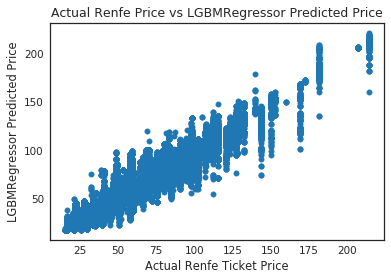

In [49]:
plt.scatter(Y_test, lg_predict)
plt.xlabel("Actual Renfe Ticket Price")
plt.ylabel("LGBMRegressor Predicted Price")
plt.title("Actual Renfe Price vs LGBMRegressor Predicted Price")

In [50]:
def plot_feature(alg,dtrain,top=25):
    """Feature importance plot"""
    feat_imp = pd.Series(alg.feature_importances_,index=dtrain.columns).sort_values(ascending=False)[0:top]
    feat_imp.plot(kind='bar', title='top {} Feature Importances'.format(top))
    plt.ylabel('Feature Importance Score')
    plt.show()

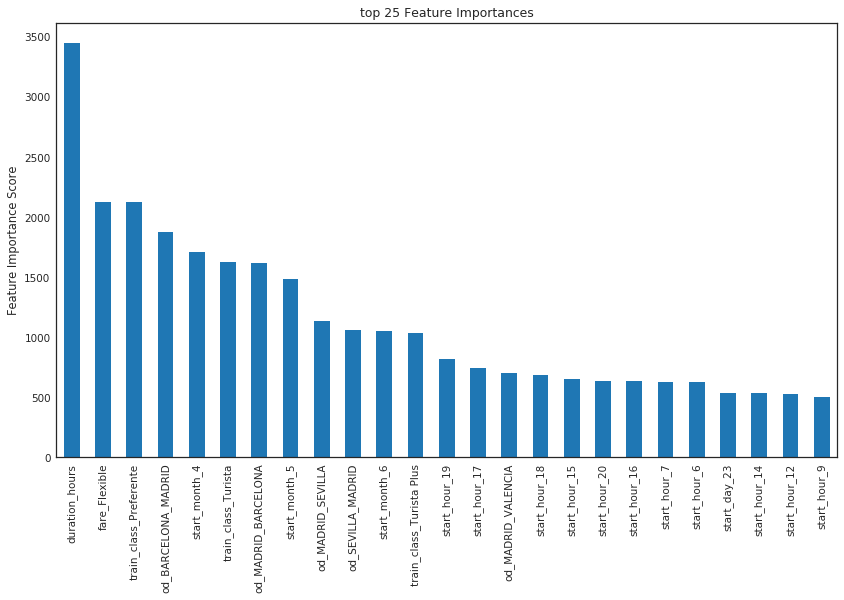

In [51]:
plt.figure(figsize=(14,8))
plot_feature(lg_best,dtrain=X_train)